Here we take the cadherin interactome data and the lysine modification data and look for enrichment of lysine acylations in the cadherin interactome

In [210]:
import os
import collections

import pandas as pd
import numpy as np

import CGAT.IOTools as IOTools

%load_ext rpy2.ipython

In [178]:
results_dir = "./results/"
raw_dir = "../raw"
lysine_mod_inf = os.path.join(results_dir, 'lysine_modification.tsv')

cadherin_inf = os.path.join(results_dir, "cadherine_proteins.tsv")
cadherin_glass_inf = os.path.join(results_dir, "ecadherin_glass.tsv")
cadherin_biotin_inf = os.path.join(results_dir, "ecadherin_biotin.tsv")

paxdf_inf = os.path.join(raw_dir, '10090-WHOLE_ORGANISM-integrated.txt')

In [58]:
lysine_df = pd.read_table(lysine_mod_inf, sep="\t")
print(lysine_df.head())
print(lysine_df[lysine_df['Protein']=='Q9JLT4'])

def pivotResetAndBoolify(index):
    lysine_pivot = lysine_df.pivot_table(
        values='ratio', index=index, columns='Modification', aggfunc=lambda x: len(x)>0)
    lysine_pivot = lysine_pivot.fillna(0)
    lysine_pivot.reset_index(inplace=True)
    lysine_pivot.columns.name = None
    
    return lysine_pivot


lysine_protein_df = pivotResetAndBoolify(['Protein'])
lysine_protein_study_df = pivotResetAndBoolify(['Protein', 'Reference'])
lysine_position_df = pivotResetAndBoolify(['Protein', 'Position'])

print(lysine_protein_df[lysine_protein_df['Protein']=='Q9JLT4'])
print(lysine_protein_study_df[lysine_protein_study_df['Protein']=='Q9JLT4'])
print(lysine_position_df[lysine_position_df['Protein']=='Q9JLT4'])

  Protein  Position   Modification             Reference  ratio  p_value
0  Q9JLT4       337  succinylation  Sadhukhan_et_al_2016   1.47     -1.0
1  Q61425       179  succinylation  Sadhukhan_et_al_2016   1.07     -1.0
2  Q61425       241  succinylation  Sadhukhan_et_al_2016   1.33     -1.0
3  Q9JLZ3       179  succinylation  Sadhukhan_et_al_2016   4.70     -1.0
4  Q9CZU6       450  succinylation  Sadhukhan_et_al_2016  57.68     -1.0
      Protein  Position   Modification             Reference  ratio  p_value
0      Q9JLT4       337  succinylation  Sadhukhan_et_al_2016   1.47     -1.0
5186   Q9JLT4        64  glutarylation        Tan_et_al_2014  -1.00     -1.0
5187   Q9JLT4       337  glutarylation        Tan_et_al_2014  -1.00     -1.0
5188   Q9JLT4       329  glutarylation        Tan_et_al_2014  -1.00     -1.0
5189   Q9JLT4       285  glutarylation        Tan_et_al_2014  -1.00     -1.0
5190   Q9JLT4       137  glutarylation        Tan_et_al_2014  -1.00     -1.0
9032   Q9JLT4       337

In [64]:
lysine_position_df['competitive_modifications'] = [x==3 for x in lysine_position_df[
        ['acetylation', 'malonylation', 'succinylation']].apply(sum, 1).tolist()]

lysine_protein_df['all_modifications'] = [x == 3 for x in lysine_protein_df[
        ['acetylation', 'malonylation', 'succinylation']].apply(sum, 1)]

print(lysine_position_df.head(2))
print(lysine_protein_df.head(2))

lysine_df_pivot.to_csv(os.path.join(results_dir, 'lysine_modification_summary.tsv'), sep='\t')

  Protein  Position  acetylation  glutarylation  malonylation  succinylation  \
0  A0AUV1         5          1.0            0.0           0.0            0.0   
1  A0AUV1         9          1.0            0.0           0.0            0.0   

   succinylation_SIRT5_KO competitive_modifications  
0                     0.0                     False  
1                     0.0                     False  
  Protein  acetylation  glutarylation  malonylation  succinylation  \
0  A0AUV1          1.0            0.0           0.0            0.0   
1  A0JLP6          1.0            0.0           0.0            0.0   

   succinylation_SIRT5_KO all_modifications  
0                     0.0             False  
1                     0.0             False  


Next we use the localisations from the hyperlopit data


In [72]:
lopit_df = pd.read_table('~/WT/NML/hyperLOPIT-enrichment/R/hl_subset.tsv', sep='\t')
lopit_df = lopit_df[['uniprot.accession', 'Final.Localization.Assignment']]
print(lopit_df.columns)
print(lopit_df.shape)
print(lopit_df.head())

Index(['uniprot.accession', 'Final.Localization.Assignment'], dtype='object')
(4413, 2)
  uniprot.accession Final.Localization.Assignment
0            Q9JHU4                  unclassified
1            Q9ERU9           Nucleus - Chromatin
2            P26039            Actin cytoskeleton
3            Q8BTM8                  unclassified
4            A2ARV4                  unclassified


Then we add the cadherin data

In [97]:
print("P26231" in lopit_df['uniprot.accession'])
print("Q65CL1" in lopit_df['uniprot.accession'])
print("P26231" in lysine_protein_df['Protein'])
print("Q65CL1" in lysine_protein_df['Protein'])

False
False
False
False


In [173]:
def readCadherin(infile, column_name, abundance_column=None, sep=","):
    df = pd.read_table(infile, sep=sep)
    df[column_name] = 1
    df = df[df['Mouse_uniprot_IDs'].notnull()]
    print(df.columns)
    
    if abundance_column:
        df = df[['Mouse_uniprot_IDs', column_name, abundance_column]]
    else:
        df = df[['Mouse_uniprot_IDs', column_name]]
    df.set_index('Mouse_uniprot_IDs', inplace=True)

    return df
    
cadherin_interactome_df  = readCadherin(
    cadherin_inf, "cadherin_interactome", sep=",")
ecadherin_glass_interactome_df = readCadherin(
    cadherin_glass_inf, "ecadherin_glass_interactome", "interactome_abundance",)
ecadherin_biotin_interactome_df = readCadherin(
    cadherin_biotin_inf, "ecadherin_biotin_interactome", "interactome_abundance")

ecadherin_glass_interactome_df.rename(
    columns={'interactome_abundance':'glass_interactome_abundance'}, inplace=True)
ecadherin_biotin_interactome_df.rename(
    columns={'interactome_abundance':'biotin_interactome_abundance'}, inplace=True)

print(ecadherin_glass_interactome_df.head())
print(len(set(cadherin_interactome_df.index)))
print(len(set(lopit_df['uniprot.accession'])))
print(len(set(cadherin_interactome_df.index).intersection
          (set(lopit_df['uniprot.accession']))))


Index(['Mouse_uniprot_IDs', 'cadherin_interactome'], dtype='object')
Index(['Mouse_uniprot_IDs', 'Human_uniprot_IDs', 'interactome_abundance',
       'rank', 'ecadherin_glass_interactome'],
      dtype='object')
Index(['Mouse_uniprot_IDs', 'Human_uniprot_IDs', 'interactome_abundance',
       'rank', 'ecadherin_biotin_interactome'],
      dtype='object')
                   ecadherin_glass_interactome  glass_interactome_abundance
Mouse_uniprot_IDs                                                          
P10126                                       1                     6.333808
P68372                                       1                     2.546583
P68373                                       1                     2.252746
Q9D8N0                                       1                     1.795667
P62827                                       1                     1.763019
130
4413
76


Now we bring in the paxdb protein abundance data

In [207]:
ensembl2Uniprot = {}
with IOTools.openFile("../raw/MOUSE_10090_idmapping_selected.tab.gz", "r") as inf:
    for line in inf:
        line = line.strip().split("\t")
        try:
            proteins = line[20].split("; ")
            for protein in proteins:
                if len(protein) > 0:
                    ensembl2Uniprot[protein] = line[0]
        except:
            pass

def parseAbundance(infile, abundance_column_name='abundance'):
    abundance_df = pd.read_table(infile, sep="\t",comment='#', header=None, usecols=[1,2])

    abundance_df.columns = ["id", abundance_column_name]
    abundance_df['id'] = [x.split(".")[1] for x in abundance_df['id']]
    abundance_df['uniprot_id'] = [ensembl2Uniprot[x] if x in ensembl2Uniprot else "" for x in abundance_df['id']]
    abundance_df = abundance_df[[len(x) > 0 for x in abundance_df['uniprot_id']]]
    abundance_df = pd.DataFrame(
        abundance_df.groupby(["uniprot_id"])[abundance_column_name].agg(np.mean)).reset_index()
    #abundance_df['length'] = [protein_lengths[x] if x in protein_lengths else None
    #                      for x in abundance_df['uniprot_id']]
    return abundance_df

full_abundance_df = parseAbundance(paxdf_inf, "integrated_abundance")
print(full_abundance_df.head())
print(len(set(merged_protein_df['uniprot.accession'])))


   uniprot_id  integrated_abundance
0  A0A023T778                34.000
1  A0A067XG46                 0.086
2  A0A096P6K7                 0.228
3  A0A0A0MQ68               101.000
4  A0A0A0MQ69                 1.810
5062


In [278]:
print(lopit_df.shape)


print(lysine_protein_study_df.shape)

merged_protein_df = pd.merge(lopit_df, lysine_protein_study_df.set_index("Protein"),
                     left_on='uniprot.accession', right_index=True, how='outer')
merged_protein_df['Final.Localization.Assignment'].fillna("Not in hyperLOPIT", inplace=True)

print(merged_protein_df.columns)
print(merged_protein_df.shape)
print(cadherin_interactome_df.shape)

merged_protein_df = pd.merge(merged_protein_df, cadherin_interactome_df,
                             left_on='uniprot.accession', right_index=True, how='outer')

#print(merged_protein_df['uniprot.accession'][0:10])
#print(ecadherin_glass_interactome_df['Mouse_uniprot_IDs'][0:10])
#print(ecadherin_biotin_interactome_df['Mouse_uniprot_IDs'][0:10])
print(merged_protein_df.shape)
print(ecadherin_glass_interactome_df.shape)

merged_protein_df = pd.merge(merged_protein_df, ecadherin_glass_interactome_df,
                             left_on='uniprot.accession', right_index=True, how='outer')

print(merged_protein_df.shape)
print(ecadherin_biotin_interactome_df.shape)

merged_protein_df = pd.merge(merged_protein_df, ecadherin_biotin_interactome_df,
                             left_on='uniprot.accession', right_index=True, how='outer')

#merged_protein_df['cadherin_interactome'].fillna(0, inplace=True)
#merged_protein_df['ecadherin_glass_interactome'].fillna(0, inplace=True)
#merged_protein_df['ecadherin_biotin_interactome'].fillna(0, inplace=True)
merged_protein_df['Final.Localization.Assignment'].fillna("Not in hyperLOPIT", inplace=True)
merged_protein_df['Reference'].fillna("NA", inplace=True)
merged_protein_df.fillna(0, inplace=True)

print(merged_protein_df.shape)
print(full_abundance_df.shape)

merged_protein_df = pd.merge(merged_protein_df, full_abundance_df.set_index("uniprot_id"),
                             left_on="uniprot.accession", right_index=True,
                             how='right')
#merged_protein_df.drop('Protein', axis=1, inplace=True)
print(merged_protein_df.shape)
print(merged_protein_df.head())

(4413, 2)
(6816, 7)
Index(['uniprot.accession', 'Final.Localization.Assignment', 'Reference',
       'acetylation', 'glutarylation', 'malonylation', 'succinylation',
       'succinylation_SIRT5_KO'],
      dtype='object')
(9793, 8)
(130, 1)
(9841, 9)
(1545, 2)
(10218, 11)
(406, 2)
(10326, 13)
(19023, 2)
(21272, 14)
  uniprot.accession Final.Localization.Assignment           Reference  \
0            Q9JHU4                  unclassified   Colaka_et_al_2015   
0            Q9JHU4                  unclassified  Nishida_et_al_2015   
0            Q9JHU4                  unclassified      Sol_et_al_2012   
0            Q9JHU4                  unclassified  Weinert_et_al_2013   
1            Q9ERU9           Nucleus - Chromatin   Colaka_et_al_2015   

   acetylation  glutarylation  malonylation  succinylation  \
0          0.0            0.0           1.0            0.0   
0          0.0            0.0           1.0            0.0   
0          1.0            0.0           0.0            0.0

In [267]:

#merged_protein_df['test'] = (merged_protein_df['uniprot.accession'].fillna("") +
#                             merged_protein_df.Protein.fillna(""))
print(merged_protein_df.head())
print(merged_protein_df[merged_protein_df['uniprot.accession'].isnull()].head(2))


  uniprot.accession Final.Localization.Assignment           Reference  \
0            Q9JHU4                  unclassified   Colaka_et_al_2015   
0            Q9JHU4                  unclassified  Nishida_et_al_2015   
0            Q9JHU4                  unclassified      Sol_et_al_2012   
0            Q9JHU4                  unclassified  Weinert_et_al_2013   
1            Q9ERU9           Nucleus - Chromatin   Colaka_et_al_2015   

   acetylation  glutarylation  malonylation  succinylation  \
0          0.0            0.0           1.0            0.0   
0          0.0            0.0           1.0            0.0   
0          1.0            0.0           0.0            0.0   
0          1.0            0.0           0.0            0.0   
1          0.0            0.0           1.0            0.0   

   succinylation_SIRT5_KO  cadherin_interactome  ecadherin_glass_interactome  \
0                     0.0                   1.0                          1.0   
0                     0.0   

In [272]:
%%R -i merged_protein_df
library(ggplot2)
print(dim(merged_protein_df))
print(head(merged_protein_df))

[1] 10326    14
  uniprot.accession Final.Localization.Assignment          Reference
1            Q9JHU4                  unclassified  Colaka_et_al_2015
2            Q9JHU4                  unclassified Nishida_et_al_2015
3            Q9JHU4                  unclassified     Sol_et_al_2012
4            Q9JHU4                  unclassified Weinert_et_al_2013
5            Q9ERU9           Nucleus - Chromatin  Colaka_et_al_2015
6            Q9ERU9           Nucleus - Chromatin     Sol_et_al_2012
  acetylation glutarylation malonylation succinylation succinylation_SIRT5_KO
1           0             0            1             0                      0
2           0             0            1             0                      0
3           1             0            0             0                      0
4           1             0            0             0                      0
5           0             0            1             0                      0
6           1             0      

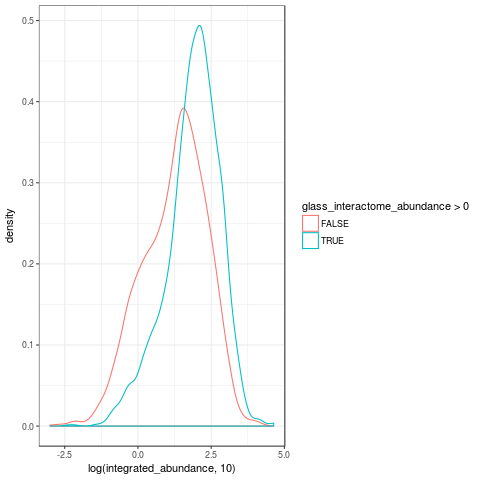

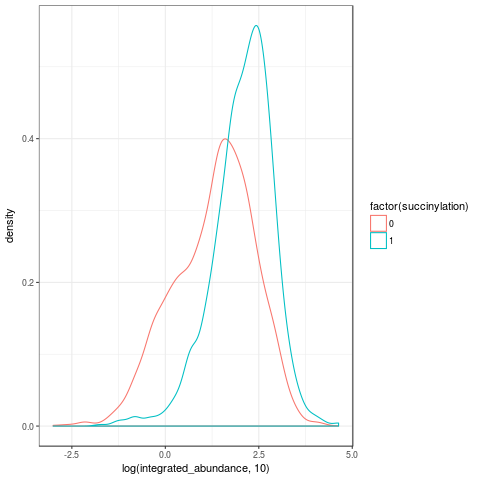

In [275]:
%%R
p = ggplot(merged_protein_df, aes(x=log(integrated_abundance,10),
                                  col=glass_interactome_abundance>0)) +
geom_density() +
theme_bw()

print(p)

p = ggplot(merged_protein_df, aes(x=log(integrated_abundance,10), col=factor(succinylation))) +
geom_density() +
theme_bw()

print(p)